<a href="https://colab.research.google.com/github/LeoVogiatzis/medical_data_analysis/blob/main/Pool_based_sampling_Active_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np

!pip install modAL
# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 1
np.random.seed(RANDOM_STATE_SEED)

In [14]:
import warnings
warnings.simplefilter('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os#Walking through directores

import plotly.graph_objects as go # Generate Graphs
from plotly.subplots import make_subplots #To Create Subplots

from sklearn import decomposition #pca
from sklearn.preprocessing import StandardScaler # Standardization ((X - X_mean)/X_std)

pd.set_option('display.max_columns', None)#Setting Max Columns Display to Max inorder to get glance of all features in dataframe

from google.colab import files
uploaded = files.upload()

Saving cardio_train.csv to cardio_train.csv


In [119]:
import io

missing_values = ['?', '--', ' ', 'NA', 'N/A', '-'] #Sometimes Missing Values are't in form of NaN
df = pd.read_csv(io.BytesIO(uploaded['cardio_train.csv']),sep=';') 
print('There are Total {} datapoints in the dataset with {} Features listed as {}:'.format(df.shape[0], df.shape[1], df.columns.values))

df

There are Total 70000 datapoints in the dataset with 13 Features listed as ['id' 'age' 'gender' 'height' 'weight' 'ap_hi' 'ap_lo' 'cholesterol'
 'gluc' 'smoke' 'alco' 'active' 'cardio']:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [120]:
df.drop(columns=['id'], inplace=True)


In [121]:
duplicate_sum = df.duplicated().sum()
if duplicate_sum:
    print('Duplicates Rows in Dataset are : {}'.format(duplicate_sum))
else:
    print('Dataset contains no Duplicate Values')


df.drop_duplicates(keep = 'first', inplace = True)
print('Total {} datapoints remaining with {} features'.format(df.shape[0], df.shape[1]))

Duplicates Rows in Dataset are : 24
Total 69976 datapoints remaining with 12 features


In [122]:
def outliers(df_out, drop = False):
    for each_feature in df_out.columns:
        feature_data = df_out[each_feature]
        Q1 = np.percentile(feature_data, 25.) # 25th percentile of the data of the given feature
        Q3 = np.percentile(feature_data, 75.) # 75th percentile of the data of the given feature
        IQR = Q3-Q1 #Interquartile Range
        outlier_step = IQR * 1.5 #That's we were talking about above
        outliers = feature_data[~((feature_data >= Q1 - outlier_step) & (feature_data <= Q3 + outlier_step))].index.tolist()  
        print('For the feature {}, No of Outliers is {}'.format(each_feature, len(outliers)))
outliers(df[['height', 'weight']])

For the feature height, No of Outliers is 519
For the feature weight, No of Outliers is 1819


In [123]:
outline_free_df = df.copy()
outline_free_df[['height', 'weight']] = np.log(outline_free_df[['height', 'weight']])
outliers(outline_free_df[['height', 'weight']])

For the feature height, No of Outliers is 484
For the feature weight, No of Outliers is 1174


In [124]:
outline_free_df = outline_free_df[(outline_free_df['weight'] > outline_free_df['weight'].quantile(0.005)) & (outline_free_df['weight'] < outline_free_df['weight'].quantile(0.995))]
outline_free_df = outline_free_df[(outline_free_df['height'] > outline_free_df['height'].quantile(0.005)) & (outline_free_df['height'] < outline_free_df['height'].quantile(0.995))]
outliers(outline_free_df[['height', 'weight']])

For the feature height, No of Outliers is 0
For the feature weight, No of Outliers is 349


In [125]:
outline_free_df = outline_free_df[outline_free_df['ap_lo']>=0]
outline_free_df = outline_free_df[outline_free_df['ap_hi']>=0]

In [126]:
cleaned_data = outline_free_df[outline_free_df['ap_hi'] >= outline_free_df['ap_lo']].reset_index(drop=True)
print('Total observations preserved : {}'.format(len(cleaned_data)))

Total observations preserved : 67156


In [127]:
cleaned_data = cleaned_data[(cleaned_data["ap_hi"]<=250) & (cleaned_data["ap_lo"]<=200)]
print('Total {} datapoints remaining with {} features'.format(cleaned_data.shape[0], cleaned_data.shape[1]))

Total 67118 datapoints remaining with 12 features


In [128]:
cleaned_data['age'] = cleaned_data['age'].div(365).apply(lambda x: int(x))

In [129]:
cleaned_data

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,5.123964,4.127134,110,80,1,1,0,0,1,0
1,55,1,5.049856,4.442651,140,90,3,1,0,0,1,1
2,51,1,5.105945,4.158883,130,70,3,1,0,0,0,1
3,48,2,5.129899,4.406719,150,100,1,1,0,0,1,1
4,47,1,5.049856,4.025352,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
67151,57,1,5.105945,4.382027,150,80,1,1,0,0,1,1
67152,52,2,5.123964,4.330733,120,80,1,1,1,0,1,0
67153,52,2,5.209486,4.653960,180,90,3,1,0,1,0,1
67154,61,1,5.093750,4.276666,135,80,1,2,0,0,0,1


In [130]:
duplicate_sum = cleaned_data.duplicated().sum()
if duplicate_sum:
    print('Duplicates Rows in Dataset are : {}'.format(duplicate_sum))
else:
    print('Dataset contains no Duplicate Values')

Duplicates Rows in Dataset are : 3180


In [131]:
cleaned_data.drop_duplicates(keep = 'first', inplace = True)
print('Total {} datapoints remaining with {} features'.format(cleaned_data.shape[0], df.shape[1]))

Total 63938 datapoints remaining with 12 features


In [132]:
target_value = cleaned_data['cardio']
cleaned_data_for_pca = cleaned_data.drop(['cardio'], axis=1)

In [133]:
scaled_data = StandardScaler().fit_transform(cleaned_data_for_pca)
scaled_data.shape

(63938, 11)

In [134]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed = pca.fit_transform(X=cleaned_data_for_pca)



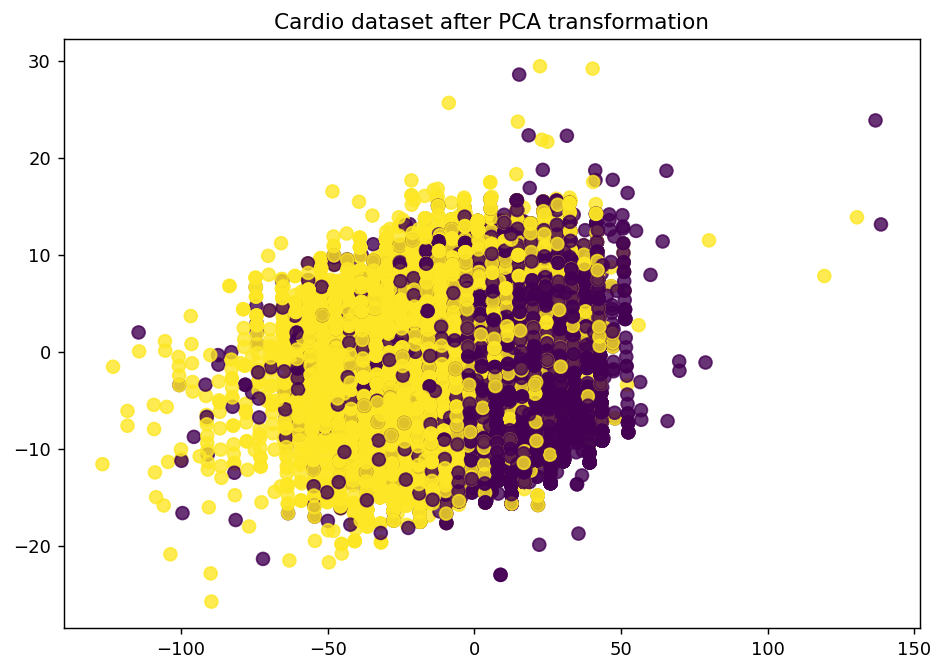

In [135]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed[:, 0], transformed[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=target_value, s=50, alpha=8/10)
plt.title('Cardio dataset after PCA transformation')
plt.show()

In [136]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = cleaned_data_for_pca.shape[0]
print(n_labeled_examples)

training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

cleaned_data_for_pca = cleaned_data_for_pca.to_numpy()
target_value = target_value.to_numpy()

X_train = cleaned_data_for_pca[training_indices]
y_train = target_value[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(cleaned_data_for_pca , training_indices, axis=0)
y_pool = np.delete(target_value, training_indices, axis=0)

63938


In [137]:
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner

# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

In [138]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(cleaned_data_for_pca)
is_correct = (predictions == target_value)

predictions

array([0, 0, 0, ..., 0, 0, 0])

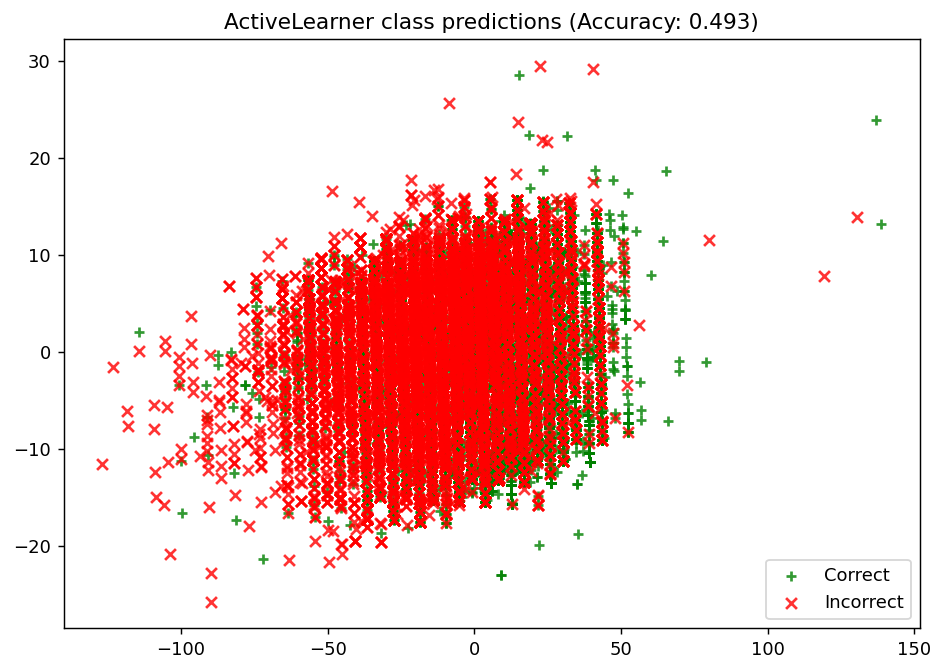

In [139]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(cleaned_data_for_pca, target_value)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [140]:
N_QUERIES = 20
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(cleaned_data_for_pca, target_value)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.4932
Accuracy after query 2: 0.6822
Accuracy after query 3: 0.7078
Accuracy after query 4: 0.6829
Accuracy after query 5: 0.6818
Accuracy after query 6: 0.6830
Accuracy after query 7: 0.6975
Accuracy after query 8: 0.6973
Accuracy after query 9: 0.6959
Accuracy after query 10: 0.6865
Accuracy after query 11: 0.6938
Accuracy after query 12: 0.6866
Accuracy after query 13: 0.6725
Accuracy after query 14: 0.6718
Accuracy after query 15: 0.6832
Accuracy after query 16: 0.6699
Accuracy after query 17: 0.6483
Accuracy after query 18: 0.6524
Accuracy after query 19: 0.6766
Accuracy after query 20: 0.6676


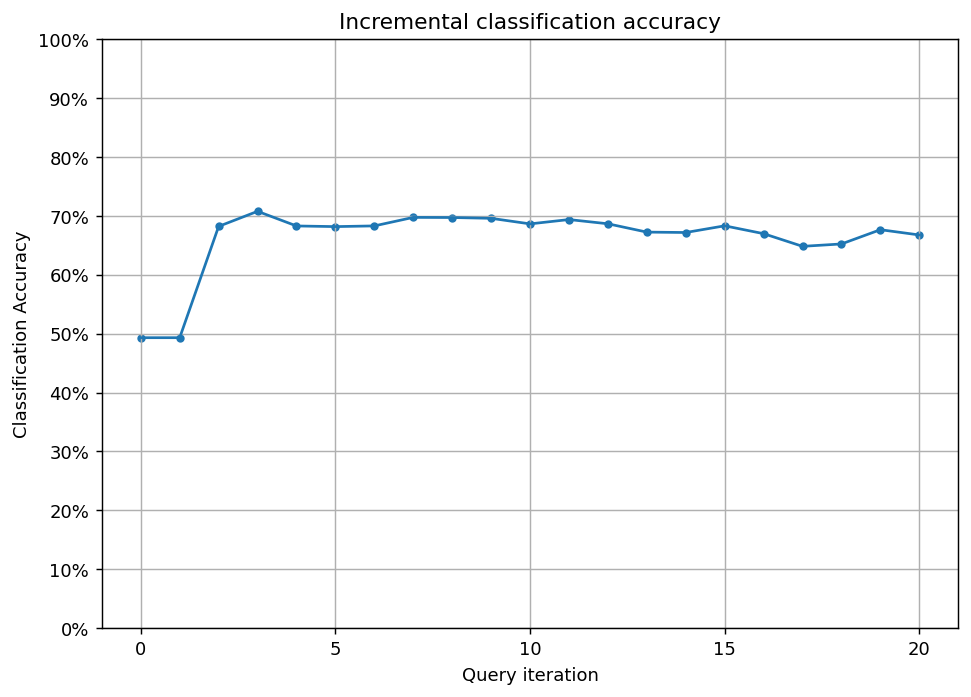

In [141]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()